In [123]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter, convolve
import scipy.stats as sps

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import cartopy.crs as ccrs
import cartopy
from cartopy.util import add_cyclic_point

import xarray as xr
import glob
import time
from xarray.ufuncs import cos, deg2rad

import os
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.e5tools import *;from tools.generalTools import *

xr.set_options(display_style='text') 
import warnings

In [5]:
from scipy.stats import linregress

def plot_timeseries(ts,ax,lbl,clr,unit='mm/day'):
    timeidxs=np.arange(len(ts))
    reg = linregress(timeidxs,ts)
    ts.plot(ax=ax,color=clr,label=lbl+", %.3f %s/decade, p=%.3f"%(10*reg.slope,unit,reg.pvalue))
    ax.plot(ts.time,reg.intercept+timeidxs*reg.slope,color=clr,linestyle='--',linewidth=0.75)
    ax.set_ylabel(unit)
    ax.legend()

In [6]:
path_frogs="/global/cfs/projectdirs/m3310/qnicolas/FROGs/1DD_V0/"

In [7]:
def era5_to_frogs_coords(ds):
    """Switch the longitude coord from (0,360) to (-180,180) and latitude from (90,-90) to (-90,90) + change names --> lat,lon"""
    dsc=ds.copy()
    dsc.coords['longitude'] = (dsc.coords['longitude']+180)%360 - 180
    #Sort the longitude values
    sort_inds = {"longitude": np.argsort(dsc["longitude"].values),"latitude": np.argsort(dsc["latitude"].values)}
    dsc = dsc.isel(**sort_inds)
    target_grid=xr.open_dataset("/global/cfs/projectdirs/m3310/qnicolas/FROGs/1DD_V0/PERSIANN_v1_r1/PERSIANN-CDRv1r1.1DD.1983.nc")
    return dsc.rename(latitude='lat',longitude='lon').interp_like(target_grid)
def quickplot(ds):
    fig, ax = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.Robinson()})
    ds.plot(ax=ax,transform=ccrs.PlateCarree())

In [8]:
orog = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.80665

In [9]:
orog_frogs=era5_to_frogs_coords(orog)
m_per_degreelat = 6370*1e3*np.pi/180
ddxorog_frogs = orog_frogs.differentiate("lon")/(m_per_degreelat*(np.cos(orog_frogs.lat*np.pi/180.)+1e-5))
ddyorog_frogs = orog_frogs.differentiate("lat")/m_per_degreelat
slope=np.sqrt(ddxorog_frogs**2+ddyorog_frogs**2)
slope_s  = xr.apply_ufunc(gaussian_filter,slope  ,kwargs={"sigma":.5})

In [10]:
%%time
persiann = xr.open_mfdataset(path_frogs+"PERSIANN_v1_r1/PERSIANN-CDRv1r1.1DD.*.nc").rain
persiann_yearly   = persiann.resample(time="1Y").mean().compute()
persiann_seasonal = persiann.resample(time="QS-DEC").mean()[1:-1].compute()


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 11.2 s, sys: 10.8 s, total: 22 s
Wall time: 25.3 s


In [33]:
cpc=xr.open_dataset(path_frogs+"CPC_v1.0/CPC.1DD.1979.nc")
landmask = cpc.rain.mean('time')>0
latmask  = (cpc.lat>-50)*(cpc.lat<50)

In [91]:
thresh=2e-3
maskmean = spatial_mean(latmask*landmask*(slope_s>thresh),mask=latmask*landmask,lat='lat',lon='lon')

# FROGs test

In [81]:
persiann = xr.open_dataset(path_frogs+"PERSIANN_v1_r1/PERSIANN-CDRv1r1.1DD.2018.nc").rain.groupby('time.season').mean('time')

In [135]:
persiann_old = xr.open_mfdataset([path_frogs+"PERSIANN_v1_r1/PERSIANN-CDRv1r1.1DD.%i.nc"%year for year in range(1983,1988)]).rain.groupby('time.season').mean('time')
warnings.simplefilter('ignore',RuntimeWarning)

In [143]:
persiann_new = xr.open_mfdataset([path_frogs+"PERSIANN_v1_r1/PERSIANN-CDRv1r1.1DD.%i.nc"%year for year in range(2013,2018)]).rain.groupby('time.season').mean('time')

In [5]:
#warnings.simplefilter('ignore',xr.SerializationWarning)
#test=xr.open_mfdataset("/global/cscratch1/sd/wboos/data/persiannCDR/1983/PERSIANN-CDR_v01r01_1983*")

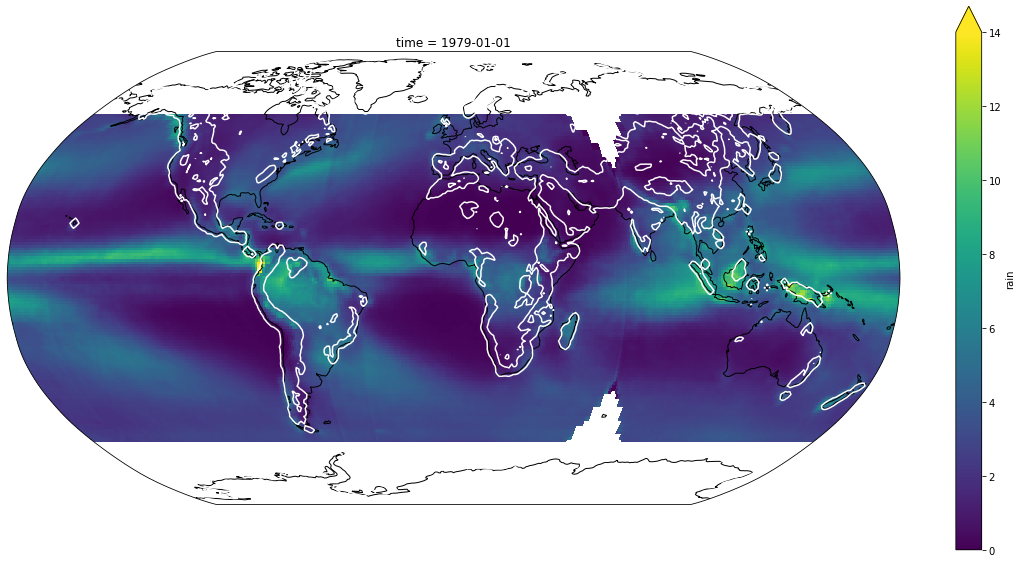

In [138]:
fig, ax = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.Robinson()})
persiann_old.mean('season').plot(ax=ax,transform=ccrs.PlateCarree(),vmin=0,vmax=14)
kw = {'levels':[thresh], 'colors':['w']}
slope_s.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
ax.coastlines()

In [139]:
persiann_mean = spatial_mean(persiann_old.mean('season'),mask=None,lat='lat',lon='lon')
persiann_orogmean = spatial_mean(persiann_old.mean('season'),mask=slope_s>thresh,lat='lat',lon='lon')
print("Global mean precip : %.3f mm/day"%persiann_mean)
print("Global mean orog precip : %.3f mm/day"%persiann_orogmean)
print("Share of orog precip: %.1f %%"%(100*persiann_orogmean/persiann_mean*maskmean))


Global mean precip : 2.900 mm/day
Global mean orog precip : 2.561 mm/day
Share of orog precip: 11.5 %


In [141]:
for seas in persiann_old.season.values:
    persiann_mean = spatial_mean(persiann_old.sel(season=seas),mask=None,lat='lat',lon='lon')
    persiann_orogmean = spatial_mean(persiann_old.sel(season=seas),mask=slope_s>thresh,lat='lat',lon='lon')
    print("Share of orog precip, %s : %.1f %%"%(str(seas),100*persiann_orogmean/persiann_mean*maskmean))


Share of orog precip, DJF : 10.4 %
Share of orog precip, JJA : 13.1 %
Share of orog precip, MAM : 11.1 %
Share of orog precip, SON : 11.4 %


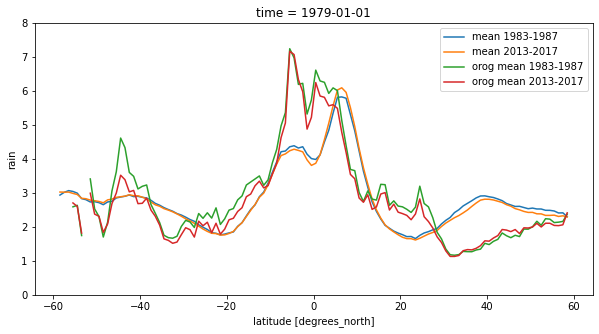

In [145]:
_,ax=plt.subplots(1,1,figsize=(10,5))
persiann_old.mean(['season','lon']).plot(ax=ax, label='mean 1983-1987')
persiann_new.mean(['season','lon']).plot(ax=ax, label='mean 2013-2017')
(persiann_old.where(slope_s>thresh)).mean(['season','lon']).plot(ax=ax, label='orog mean 1983-1987')
(persiann_new.where(slope_s>thresh)).mean(['season','lon']).plot(ax=ax, label='orog mean 2013-2017')
ax.set_ylim(0,8)
ax.legend()

## PERSIANN hi res

In [237]:
warnings.simplefilter('ignore',xr.SerializationWarning)
persiann_hr_2010=xr.open_mfdataset("/global/cscratch1/sd/wboos/data/persiannCDR/2010/PERSIANN-CDR_v01r01_2010*")

In [239]:
to_plot=persiann_hr_2010.precipitation.mean('time').load()

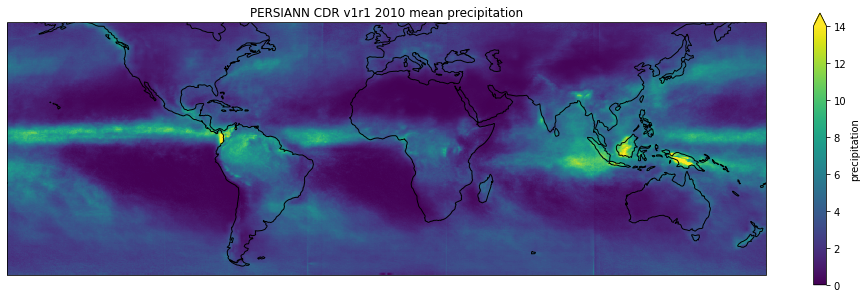

In [250]:
fig, ax = plt.subplots(1,1,figsize=(17,5),subplot_kw={'projection': ccrs.PlateCarree()})
to_plot.plot(ax=ax,x='lon',vmin=0,vmax=14,transform=ccrs.PlateCarree())
ax.set_title("PERSIANN CDR v1r1 2010 mean precipitation")
ax.coastlines()

# Mean precip trends & share trends & by season

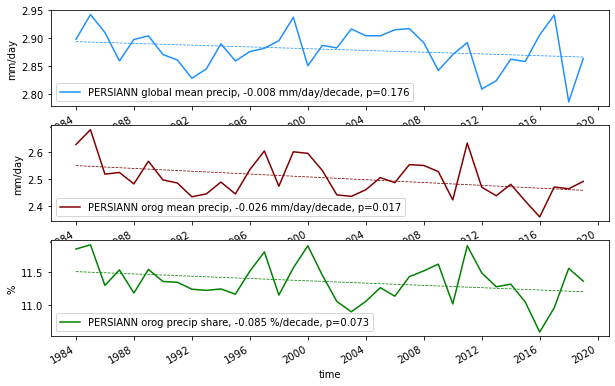

In [190]:
# Mean precip trend
_,(ax,ax2,ax3)=plt.subplots(3,1,figsize=(10,6))
plot_timeseries(spatial_mean(persiann_yearly,mask=None,lat='lat',lon='lon'),ax,"PERSIANN global mean precip",'dodgerblue')
plot_timeseries(spatial_mean(persiann_yearly,mask=slope_s>thresh,lat='lat',lon='lon'),ax2,"PERSIANN orog mean precip",'maroon')
plot_timeseries(100*spatial_mean(persiann_yearly,mask=slope_s>thresh,lat='lat',lon='lon')/spatial_mean(persiann_yearly,mask=None,lat='lat',lon='lon')*maskmean,ax3,"PERSIANN orog precip share",'green',unit='%')

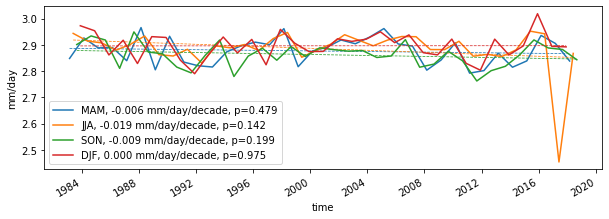

In [191]:
clrs=plt.rcParams["axes.prop_cycle"].by_key()["color"]
# Mean precip trend
_,ax=plt.subplots(1,1,figsize=(10,3))
plot_timeseries(spatial_mean(persiann_seasonal[::4] ,mask=None,lat='lat',lon='lon'),ax,'MAM',clrs[0])
plot_timeseries(spatial_mean(persiann_seasonal[1::4],mask=None,lat='lat',lon='lon'),ax,'JJA',clrs[1])
plot_timeseries(spatial_mean(persiann_seasonal[2::4],mask=None,lat='lat',lon='lon'),ax,'SON',clrs[2])
plot_timeseries(spatial_mean(persiann_seasonal[3::4],mask=None,lat='lat',lon='lon'),ax,'DJF',clrs[3])
ax.legend()

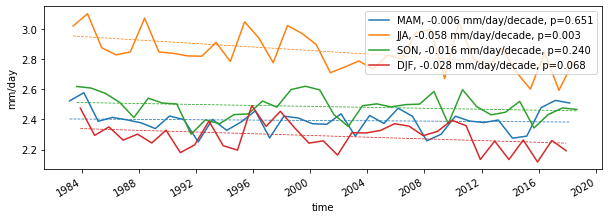

In [192]:
clrs=plt.rcParams["axes.prop_cycle"].by_key()["color"]
# Mean precip trend
_,ax=plt.subplots(1,1,figsize=(10,3))
plot_timeseries(spatial_mean(persiann_seasonal[::4] ,mask=slope_s>thresh,lat='lat',lon='lon'),ax,'MAM',clrs[0])
plot_timeseries(spatial_mean(persiann_seasonal[1::4],mask=slope_s>thresh,lat='lat',lon='lon'),ax,'JJA',clrs[1])
plot_timeseries(spatial_mean(persiann_seasonal[2::4],mask=slope_s>thresh,lat='lat',lon='lon'),ax,'SON',clrs[2])
plot_timeseries(spatial_mean(persiann_seasonal[3::4],mask=slope_s>thresh,lat='lat',lon='lon'),ax,'DJF',clrs[3])
ax.legend()

# Comparing CHIRPS/REGEN/Persiann/CRU

In [12]:
chirps = xr.open_mfdataset(path_frogs+"CHIRPS_v2.0/*.nc").rain
chirps_yearly   = chirps.resample(time="1Y").mean().compute()
chirps_seasonal = chirps.resample(time="QS-DEC").mean()[1:-1].compute()

#gpcc = xr.open_mfdataset(path_frogs+"GPCC_FDD_2018/*.nc").precip
#gpcc_yearly   = gpcc.resample(time="1Y").mean().compute()
#gpcc_seasonal = gpcc.resample(time="QS-DEC").mean()[1:-1].compute()

regen = xr.open_mfdataset(path_frogs+"REGEN_LONG_V1-2019/*.nc").p
regen_yearly   = regen.resample(time="1Y").mean().compute()
regen_seasonal = regen.resample(time="QS-DEC").mean()[1:-1].compute()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [112]:
cru = xr.open_mfdataset("/global/cfs/projectdirs/m3310/qnicolas/CRU-TS-v4.05/*.nc")
landmask_cru = 1-np.isnan(cru.pre[:12].resample(time="1Y").mean().compute()[0])
cru_yearly = cru.pre.resample(time="1Y").sum().compute()/365.25
cru_yearly=cru_yearly.where(landmask_cru)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [96]:
slope_s_cru=slope_s.interp_like(cru)
latmask_cru = (cru.lat>-50)*(cru.lat<50)
latmaskmean_cru = spatial_mean(latmask_cru*landmask_cru*(slope_s_cru>thresh),mask=latmask_cru*landmask_cru,lat='lat',lon='lon')

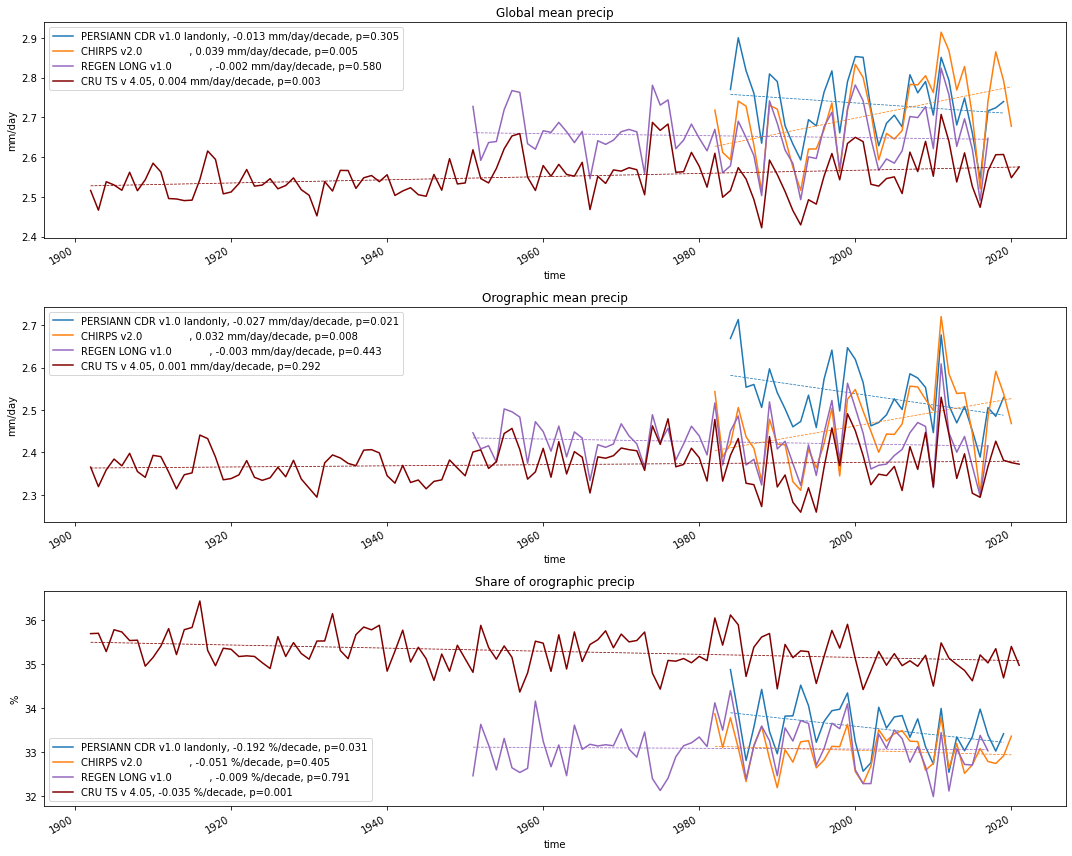

In [97]:
clrs=plt.rcParams["axes.prop_cycle"].by_key()["color"]
# Mean precip trend
fig,(ax,ax2,ax3)=plt.subplots(3,1,figsize=(15,12))
plot_timeseries(spatial_mean(persiann_yearly,mask=latmask*landmask,lat='lat',lon='lon'),ax,'PERSIANN CDR v1.0 landonly',clrs[0])
plot_timeseries(spatial_mean(chirps_yearly  ,mask=latmask         ,lat='lat',lon='lon'),ax,'CHIRPS v2.0               ',clrs[1])
#plot_timeseries(spatial_mean(gpcc_yearly    ,mask=latmask         ,lat='lat',lon='lon'),ax,'GPCC v2018                ',clrs[3])
plot_timeseries(spatial_mean(regen_yearly   ,mask=latmask         ,lat='lat',lon='lon'),ax,'REGEN LONG v1.0            ',clrs[4])

plot_timeseries(spatial_mean(persiann_yearly,mask=latmask*(slope_s>thresh)*landmask,lat='lat',lon='lon'),ax2,'PERSIANN CDR v1.0 landonly',clrs[0])
plot_timeseries(spatial_mean(chirps_yearly  ,mask=latmask*(slope_s>thresh),lat='lat',lon='lon')         ,ax2,'CHIRPS v2.0               ',clrs[1])
#plot_timeseries(spatial_mean(gpcc_yearly    ,mask=latmask*(slope_s>thresh),lat='lat',lon='lon')         ,ax2,'GPCC v2018                ',clrs[3])
plot_timeseries(spatial_mean(regen_yearly   ,mask=latmask*(slope_s>thresh),lat='lat',lon='lon')         ,ax2,'REGEN LONG v1.0            ',clrs[4])

plot_timeseries(100*spatial_mean(persiann_yearly,mask=latmask*(slope_s>thresh)*landmask,lat='lat',lon='lon')/spatial_mean(persiann_yearly,mask=latmask*landmask,lat='lat',lon='lon')*maskmean,ax3,'PERSIANN CDR v1.0 landonly',clrs[0],unit='%')
plot_timeseries(100*spatial_mean(chirps_yearly  ,mask=latmask*(slope_s>thresh),lat='lat',lon='lon')         /spatial_mean(chirps_yearly  ,mask=latmask         ,lat='lat',lon='lon')*maskmean,ax3,'CHIRPS v2.0               ',clrs[1],unit='%')
#plot_timeseries(100*spatial_mean(gpcc_yearly    ,mask=latmask*(slope_s>thresh),lat='lat',lon='lon')         /spatial_mean(gpcc_yearly    ,mask=latmask         ,lat='lat',lon='lon')*maskmean,ax3,'GPCC v2018                ',clrs[3],unit='%')
plot_timeseries(100*spatial_mean(regen_yearly   ,mask=latmask*(slope_s>thresh),lat='lat',lon='lon')         /spatial_mean(regen_yearly   ,mask=latmask         ,lat='lat',lon='lon')*maskmean,ax3,'REGEN LONG v1.0            ',clrs[4],unit='%')

plot_timeseries(spatial_mean(cru_yearly,mask=latmask_cru,lat='lat',lon='lon'),ax,'CRU TS v 4.05',"maroon")
plot_timeseries(spatial_mean(cru_yearly,mask=latmask_cru*(slope_s_cru>thresh),lat='lat',lon='lon'),ax2,'CRU TS v 4.05',"maroon")
plot_timeseries(100*spatial_mean(cru_yearly,mask=latmask_cru*(slope_s_cru>thresh),lat='lat',lon='lon')/spatial_mean(cru_yearly,mask=latmask_cru,lat='lat',lon='lon')*latmaskmean_cru,ax3,'CRU TS v 4.05',"maroon",unit='%')


ax.set_title('Global mean precip')
ax2.set_title('Orographic mean precip')
ax3.set_title('Share of orographic precip')
fig.tight_layout()

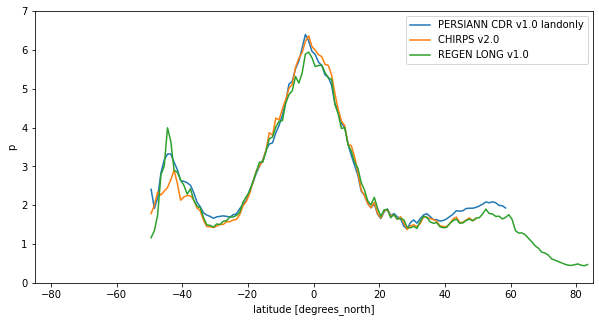

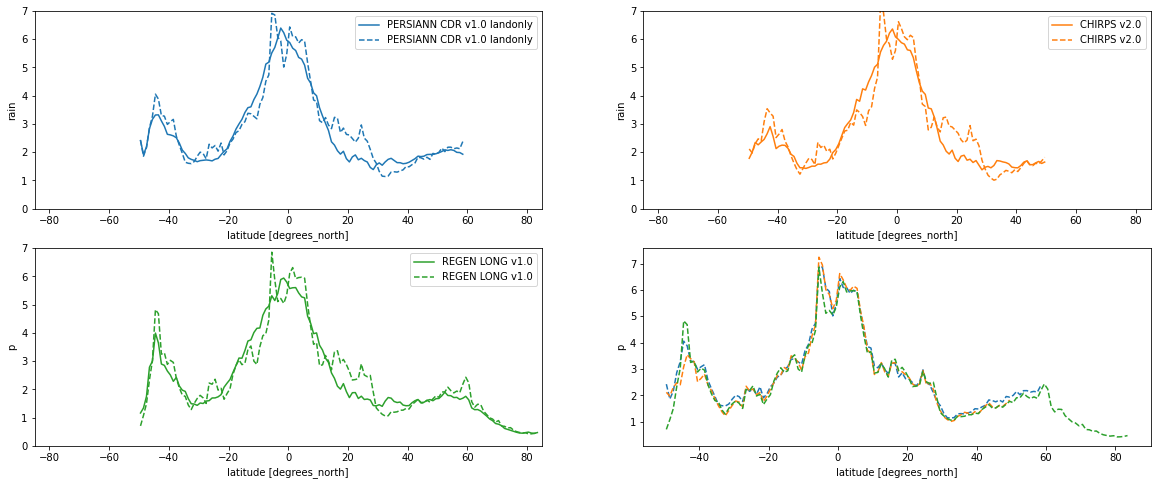

In [35]:
_,ax=plt.subplots(1,1,figsize=(10,5))
persiann_yearly.where(landmask).mean(['time','lon']).sel(lat=slice(-50,90)).plot(ax=ax, label='PERSIANN CDR v1.0 landonly')
chirps_yearly  .mean(['time','lon']).sel(lat=slice(-50,90)).plot(ax=ax, label='CHIRPS v2.0               ')
#gpcc_yearly    .mean(['time','lon']).sel(lat=slice(-50,90)).plot(ax=ax, label='GPCC v2018                ')
regen_yearly   .mean(['time','lon']).sel(lat=slice(-50,90)).plot(ax=ax, label='REGEN LONG v1.0            ')

#persiann_yearly.where(slope_s>thresh).where(landmask).mean(['time','lon']).sel(lat=slice(-50,90)).plot(ax=ax, label='PERSIANN CDR v1.0 landonly',color=clrs[0],linestyle='--')
#chirps_yearly  .where(slope_s>thresh).mean(['time','lon']).sel(lat=slice(-50,90)).plot(ax=ax, label='CHIRPS v2.0               '                ,color=clrs[1],linestyle='--')
##gpcc_yearly    .where(slope_s>thresh).mean(['time','lon']).sel(lat=slice(-50,90)).plot(ax=ax, label='GPCC v2018                '                ,color=clrs[3],linestyle='--')
#regen_yearly   .where(slope_s>thresh).mean(['time','lon']).sel(lat=slice(-50,90)).plot(ax=ax, label='REGEN LONG v1.0            '                ,color=clrs[4],linestyle='--')


ax.set_xlim(-85,85)
ax.set_ylim(0,7)
ax.legend()

_,axs=plt.subplots(2,2,figsize=(20,8))
axs=axs.reshape(-1)
for ds,ax,lbl,clr in zip((persiann_yearly.where(landmask),chirps_yearly,regen_yearly,cru_yearly),axs,('PERSIANN CDR v1.0 landonly','CHIRPS v2.0','REGEN LONG v1.0'),clrs):
    ds.mean(['time','lon']).sel(lat=slice(-50,90)).plot(ax=ax, label=lbl,color=clr)
    ds.where(slope_s>thresh).mean(['time','lon']).sel(lat=slice(-50,90)).plot(ax=ax, label=lbl,color=clr,linestyle='--')
    ax.set_xlim(-85,85)
    ax.set_ylim(0,7)
    ax.legend()

In [36]:
print("Share of orographic regions over all land : %.1f%%"%(100*spatial_mean((slope_s>thresh)*landmask,mask=None,lat='lat',lon='lon')/spatial_mean(landmask,mask=None,lat='lat',lon='lon')))

Share of orographic regions over all land : 38.2%


Text(0.5, 1.0, 'Share of land surface occupied by orographic regions')

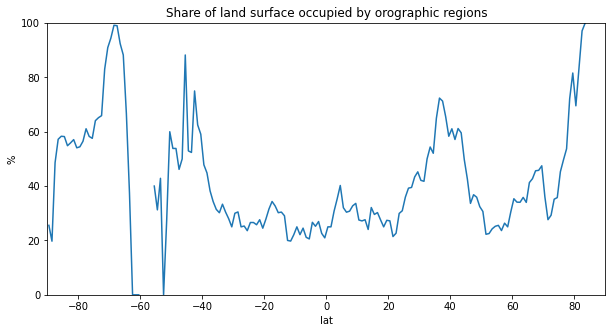

In [37]:
_,ax=plt.subplots(1,1,figsize=(10,5))
(100*(slope_s>thresh)).where(landmask).mean('lon').plot(ax=ax, label='share of orographic land')
ax.set_xlim(-90,90)
ax.set_ylim(0,100)
ax.set_ylabel('%')
ax.set_title('Share of land surface occupied by orographic regions')

# CRU

In [100]:
maskmean_cru = spatial_mean(landmask_cru*(slope_s_cru>thresh),mask=landmask_cru,lat='lat',lon='lon')

In [ ]:
cru_yearly

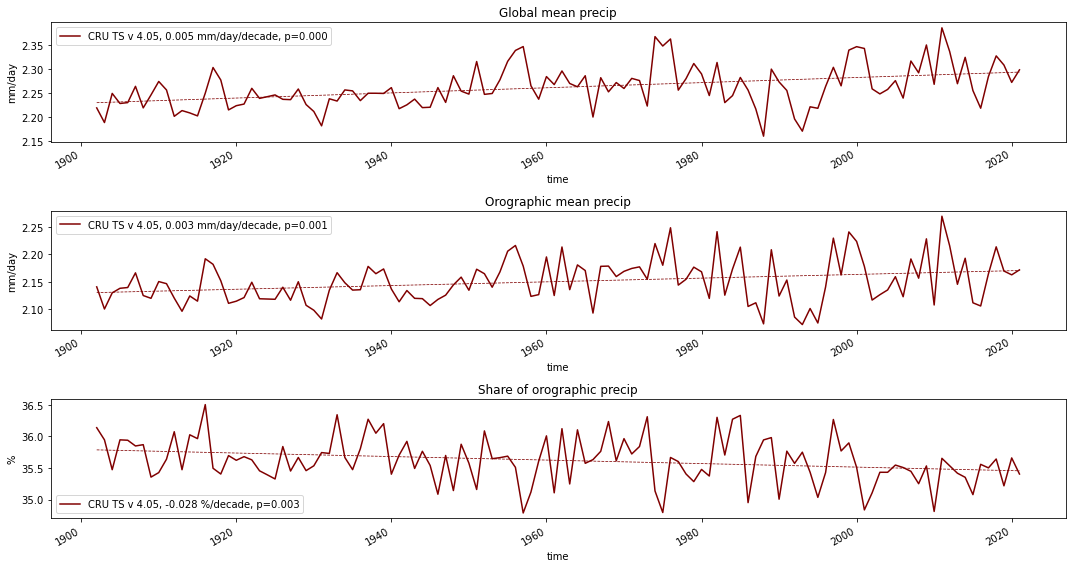

In [101]:
clrs=plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig,(ax,ax2,ax3)=plt.subplots(3,1,figsize=(15,8))

plot_timeseries(spatial_mean(cru_yearly,lat='lat',lon='lon'),ax,'CRU TS v 4.05',"maroon")
plot_timeseries(spatial_mean(cru_yearly,mask=(slope_s_cru>thresh),lat='lat',lon='lon'),ax2,'CRU TS v 4.05',"maroon")
plot_timeseries(100*spatial_mean(cru_yearly,mask=(slope_s_cru>thresh),lat='lat',lon='lon')/spatial_mean(cru_yearly,lat='lat',lon='lon')*maskmean_cru,ax3,'CRU TS v 4.05',"maroon",unit='%')

ax.set_title('Global mean precip')
ax2.set_title('Orographic mean precip')
ax3.set_title('Share of orographic precip')
fig.tight_layout()

# Maps

In [173]:
def quick_map(mapdata,title=None,cb_ttl=None,cmap=None,clim=None,
              sigmask=None,p=None,figsize=None,stride=1):
    lat=mapdata.lat;lon=mapdata.lon
    if figsize:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure(figsize=(20,15))
    
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.set_global()

    cyclic_data, cyclic_lons = add_cyclic_point(mapdata,coord=lon)

    #cs = plt.contourf(cyclic_lons,lat,cyclic_data,60,transform=ccrs.PlateCarree(),extend='both')#,vmin=clim[0],vmax=clim[1])
    cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())

    if cmap:
        plt.set_cmap(cmap)
    else:
        plt.set_cmap(plt.cm.viridis)

    if title:
        plt.title(title,fontsize=16,y=1.05)
        
    if clim:
        plt.cm.ScalarMappable.set_clim(cs,vmin = clim[0],vmax = clim[1])
#         plt.clim(clim)  
#         cs.set_clim(clim[0],clim[1])
#         cs.set_clim(clim)
        
    cbar = plt.colorbar(ax=ax,orientation='horizontal',extend='both',pad=.02, shrink=0.9)
    cbar.ax.tick_params(labelsize=14) 

    if cb_ttl:
        cbar.set_label(cb_ttl,fontsize=14)

    # add hatching for significance
    if p:
        cyclic_sig, cyclic_lons = add_cyclic_point(sigmask,coord=lon)
        #hatch = plt.pcolor(cyclic_lons,lat,cyclic_sig,hatch='xxx',alpha=0.,transform=ccrs.PlateCarree()); 

        CLN, CLT = np.meshgrid(cyclic_lons,lat)

        # only put the hatches where the sigmask is >0.5
        #cyclic_sig = np.ma.masked_where(cyclic_sig<p,cyclic_sig)
        sigmask = np.where(cyclic_sig>p,1.0,np.nan)
        sigmask2 = np.ma.masked_where(cyclic_sig > p, sigmask)
        
        lat_sig = np.ma.masked_where(cyclic_sig>p,CLT)
        lat_sig = np.ma.masked_where(np.isnan(cyclic_sig),lat_sig)
        lon_sig = np.ma.masked_where(cyclic_sig>p,CLN)
        lon_sig = np.ma.masked_where(np.isnan(cyclic_sig),lon_sig)

        hatch = ax.scatter(lon_sig[::stride,::stride],lat_sig[::stride,::stride],s=sigmask2[::stride,::stride],marker='x',#s=2,
                           c=[0.6, 0.6, 0.6],alpha=0.8,transform=ccrs.PlateCarree(),)

    ax.patch.set_alpha(0.0)
    return ax

def lr(a,b):
    l,_,_,p,_=linregress(a,b)
    return l
def lrp(a,b):
    l,_,_,p,_=linregress(a,b)
    return p   

In [165]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three 
    dimensions (time,lat,lon). 
    Datasets can be provided in any order, but note that the regression slope 
    and intercept will be calculated for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, 
    and standard error on regression between the two datasets along their 
    aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and
    lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
    
        # If x lags y by 1, x must be shifted 1 step backwards. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid 
        # (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
    
        # Next important step is to re-align the two datasets so that y adjusts
        # to the changed coordinates of x
        x,y = xr.align(x,y)
    
    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
    
    #3. Compute data length, mean and standard deviation along time axis: 
    n = y.notnull().sum(dim='time')
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(np.abs(slope/stderr), n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)
    
    return cov,cor,slope,intercept,pval,stderr

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


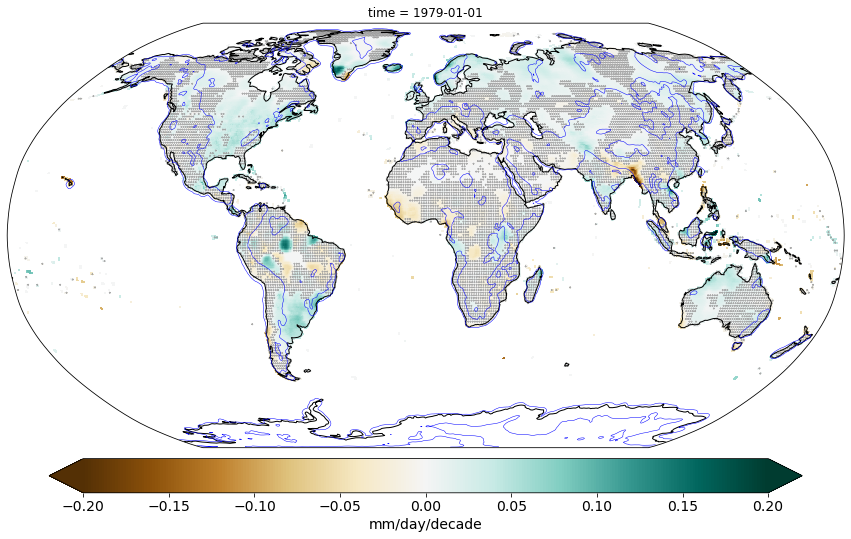

In [174]:
timeidxs=xr.DataArray(range(len(cru_yearly.time)),dims='time',coords={'time':cru_yearly.time})
_,_,slope,_,pval,_=lag_linregress_3D(timeidxs,cru_yearly)
ax=quick_map(10*slope,title="Global precipitation trends, CRU TS v4.05",cb_ttl="mm/day/decade",clim=[-0.2,0.2],cmap=plt.cm.BrBG,
              sigmask=pval,p=0.05,figsize=(15,10),stride=2)
slope_s_cru.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[thresh],colors=['b'],linewidths=[0.5])

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


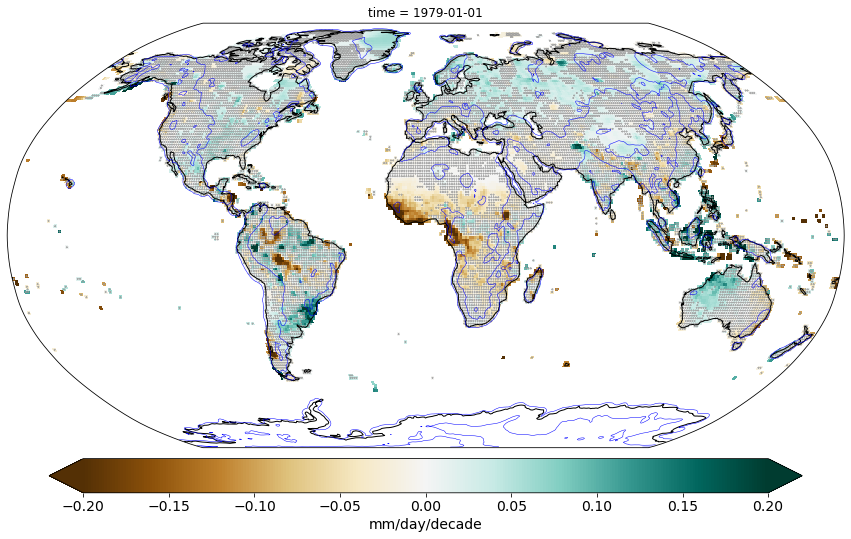

In [176]:
timeidxs=xr.DataArray(range(len(regen_yearly.time)),dims='time',coords={'time':regen_yearly.time})
_,_,slope,_,pval,_=lag_linregress_3D(timeidxs,regen_yearly)
ax=quick_map(10*slope,title="Global precipitation trends, PERSIANN CDR v1.0",cb_ttl="mm/day/decade",clim=[-0.2,0.2],cmap=plt.cm.BrBG,
              sigmask=pval,p=0.05,figsize=(15,10))
slope_s_cru.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[thresh],colors=['b'],linewidths=[0.5])

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


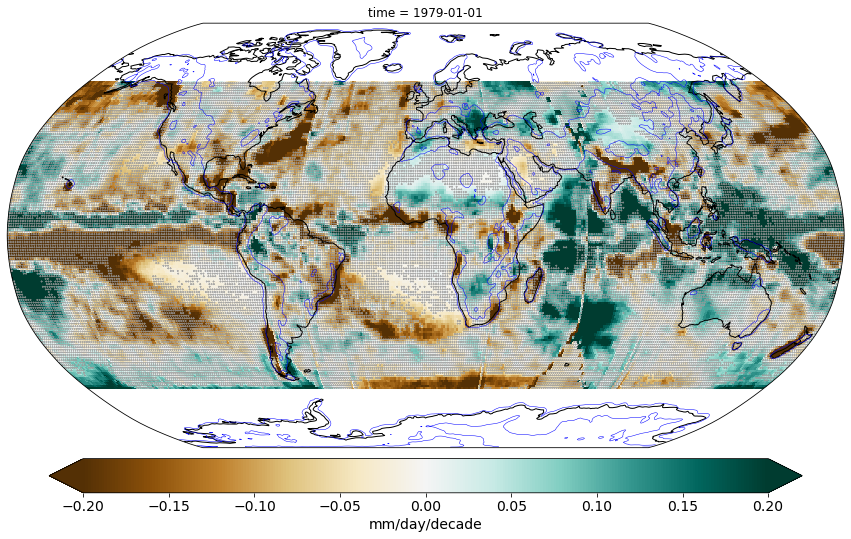

In [175]:
timeidxs=xr.DataArray(range(len(persiann_yearly.time)),dims='time',coords={'time':persiann_yearly.time})
_,_,slope,_,pval,_=lag_linregress_3D(timeidxs,persiann_yearly)
ax=quick_map(10*slope,title="Global precipitation trends, PERSIANN CDR v1.0",cb_ttl="mm/day/decade",clim=[-0.2,0.2],cmap=plt.cm.BrBG,
              sigmask=pval,p=0.05,figsize=(15,10))
slope_s_cru.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[thresh],colors=['b'],linewidths=[0.5])

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
  import sys


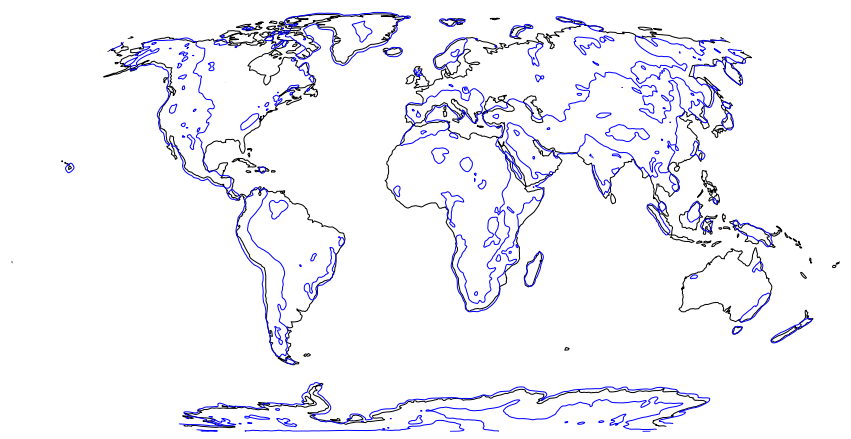

In [181]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
slope_s_cru.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[thresh],colors=['b'],linewidths=[1])
ax.set_title("")
ax.outline_patch.set_visible(False)
ax.background_patch.set_visible(False)

# Older tests

In [91]:
def gaussian_isotropic(x,y,sigma):
    return np.exp(-1/(2*sigma**2)*(x**2+y**2))

def gaussian(x,y,invcov):
    return np.exp(-1/2 * (invcov[0,0]*x**2 + (invcov[1,0]+invcov[0,1])*x*y + invcov[1,1]*y**2))

def u_invcov(u,v,alpha,sigma):
    sigma1 = sigma*np.sqrt(2/(1+alpha**2))#scaled std so that total variance = sigma**2
    rotation_matrix = 1/np.sqrt(u**2+v**2) * np.array([[u,v],[-v,u]])
    diag_matrix = np.diag([1/(alpha*sigma1)**2,1/sigma1**2])
    return np.dot(np.dot(rotation_matrix,diag_matrix),np.transpose(rotation_matrix))

def convolveCustom(f,g,mode='wrap'):
    """2D convolution with a space-varying kernel g
        g must have shape (f.shape[0],f.shape[1],ng,mg) where (ng,mg) is the kernel shape at each point"""
    rep=np.zeros(f.shape)
    ng,mg = g.shape[2:4]
    fpad = np.pad(f,(ng,mg),mode=mode)
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            rep[i,j] = np.sum(g[i,j][::-1,::-1]*fpad[ng+i- ng//2 : 2*ng+i- ng//2,mg+j- mg//2 : 2*mg+j- mg//2])
            
    return rep


def spaceVaryingAnisotropicKernel(U,V,sigma,anisotropy_factor=1):
    """Return a space-varying kernel (of shape (f.shape[0],f.shape[1],ng,ng))
    where ng=4*int(sigma) is the kernel size at each point
    The kernel is basically consituted of two parts :
     - an upstream part, which is an anisotropic gaussian kernel with total variance sigma**2,
       and a std that is alpha times bigger along the vector (U[i,j],V[i,j]) than along its orthogonal direction
       where alpha depends on the vector norm
     - a downstream part that is an isotropic gaussian kernel with total variance sigma'**2 
     (sigma' chosen to match upstream kernel shape)
    """
    assert U.shape==V.shape
    kernel_size=2*int(np.ceil(sigma))
    rep = np.zeros((U.shape[0],U.shape[1],2*kernel_size+1,2*kernel_size+1))
    X_kernel,Y_kernel = np.meshgrid(np.arange(-kernel_size,kernel_size+1),np.arange(-kernel_size,kernel_size+1))

    for i in range(U.shape[0]):
        for j in range(U.shape[1]):    
            # compute the upstream half of the kernel
            u,v = U[i,j],V[i,j]
            alpha = anisotropy_factor*(1+np.sqrt((u**2+v**2)))
            invcov = u_invcov(u,v,alpha,sigma) #inverse covariance matrix on the upstream half of the kernel
            gauss_kernel_aniso = gaussian(X_kernel,Y_kernel,invcov)
            
            #compute the downstream half of the kernel; sigma is modified to accound for the distortion of the upstream kernel
            gauss_kernel_iso = gaussian_isotropic(X_kernel,Y_kernel,sigma*np.sqrt(2/(1+alpha**2)))
            
            #final kernel is split between upstream anisotropic part and downstream isotropic part
            gauss_kernel_final = gauss_kernel_aniso*(u*X_kernel-v*Y_kernel<=0)+gauss_kernel_iso*(u*X_kernel-v*Y_kernel>0)
            rep[i,j] = gauss_kernel_final/np.sum(gauss_kernel_final)
            
    return rep

    

In [7]:
def precip_pct(mask,precipmap,globmask=1):
    """Return the share of precipitation (in %) inside 'globmask' (whole world if globmask=1)
    that falls inside 'mask'. """
    mask2 = mask.interp_like(precipmap)
    if type(globmask)==int and globmask==1 :
        globmask2=1
    else :
        globmask2 = globmask.interp_like(precipmap)
    return 100*np.array(spatial_mean(mask2*globmask2*precipmap))/np.array(spatial_mean(globmask2*precipmap))

def objfunction_iso_smoothing(thresh,pr,predictor,globmask=1):
    """Given the map of a precipitation predictor (for example the upslope flow u.grad(z)),
    compute a mask accoding to predictor>thresh and compute the according precip enhancement and area fractions"""
    
    dx = np.abs(np.array(predictor.latitude[1]-predictor.latitude[0])) #get the spatial resolution of the predictor to smooth accordingly
    mask=1.*(xr.apply_ufunc(gaussian_filter,1.*(predictor>thresh),kwargs={"sigma":0.5/dx})>0.1)
    mask=mask.interp_like(pr)
    if type(globmask)!=int:
        globmask = globmask.interp_like(pr)
    area_fraction = spatial_mean(mask*globmask)/spatial_mean(globmask)
    precip_fraction = precip_pct(mask,pr,globmask)/100
    return 100*np.array(precip_fraction/area_fraction-1), 100*area_fraction

def objfunction_aniso_smoothing(thresh,pr,predictor,kernel):
    dx = np.abs(np.array(predictor.latitude[1]-predictor.latitude[0])) #get the spatial resolution of the predictor to smooth accordingly
    unsmoothed_xr=1.*(predictor>thresh)
    t=time.time()
    rainyregion_smoothed = 1.*(convolveCustom(np.array(unsmoothed_xr),kernel)>0.01)
    print(time.time()-t)
    mask=xr.DataArray(rainyregion_smoothed,unsmoothed_xr.coords)
    mask=mask.interp_like(pr)
    area_fraction = spatial_mean(mask)
    precip_fraction = precip_pct(mask,pr)/100
    return 100*np.array(precip_fraction/area_fraction-1), 100*area_fraction
    
def plotpct(ax,objfunction,lbl,args,color=0):
    #Get the range of thresholds to use on the predictor
    predictor = args[1]
    maxtresh = 0.5*np.max(np.array(predictor))
    ts = np.linspace(0.,maxtresh,10)
    
    x = np.array([objfunction(*tuple([t]+list(args))) for t in ts])
    precip_enhancements = x[:,0]
    area_fractions = x[:,1]
    
    print("threshold for 10%% : %.1e"%np.interp(10,area_fractions[::-1],ts[::-1]))
    
    if color:
        ax.plot(area_fractions,precip_enhancements,'-x',label=lbl,color=color)
    else:
        ax.plot(area_fractions,precip_enhancements,'-x',label=lbl)
    ax.set_xscale('log')
    ax.set_xlim(100,0.5)

    ax.legend()
    ax.set_xlabel("Area fraction")
    ax.set_ylabel("Precipitation enhancement")
    ax.grid()


In [8]:
#OROGRAPHY
orog1 = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z.isel(time=0)/9.80665

m_per_degreelat = 6370*1e3*np.pi/180

coslat = np.cos(orog.latitude*np.pi/180.)
coslat += 1e-5*(1-1*(coslat>1e-5))

ddxorog = orog.differentiate("longitude")/(m_per_degreelat*coslat)
ddyorog = orog.differentiate("latitude")/m_per_degreelat

#latitude step in era5
dx5 = np.abs(np.array(ddxorog.latitude.isel(latitude=1)-ddxorog.latitude.isel(latitude=0)))

In [51]:
u100m_era5_seasmean = e5_climatology('228_246_100u',range(1975,1978),by_season=True)
v100m_era5_seasmean = e5_climatology('228_247_100v',range(1975,1978),by_season=True)
viwve_era5_seasmean = e5_climatology('162_071_viwve',range(1975,1978),by_season=True)
viwvn_era5_seasmean = e5_climatology('162_072_viwvn',range(1975,1978),by_season=True)

viwvgradz_era5_seasmean = (viwve_era5_seasmean*ddxorog + viwvn_era5_seasmean*ddyorog)
viwvgradz_era5_seasmean_s  = xr.apply_ufunc(gaussian_filter,viwvgradz_era5_seasmean  ,kwargs={"sigma":.5/dx5})

0.7176675796508789
0.6868236064910889
0.6341991424560547
0.6102113723754883


In [42]:
e5_monthly_timeseries('162_071_viwve',years=[1978])

0.5601325035095215


<xarray.DataArray 'p71.162' (time: 12, latitude: 721, longitude: 1440)>
dask.array<xarray-p71.162, shape=(12, 721, 1440), dtype=float32, chunksize=(12, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1978-01-01 1978-02-01 ... 1978-12-01
Attributes:
    long_name:  Vertical integral of eastward water vapour flux
    units:      kg m**-1 s**-1

In [43]:
viwnorm = np.sqrt(viwve_era5_seasmean**2+viwvn_era5_seasmean**2)

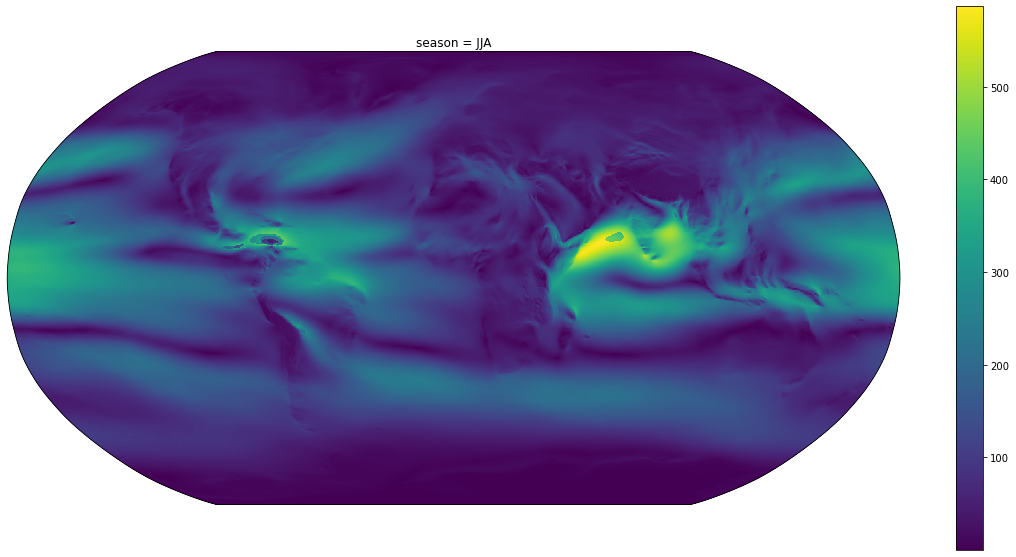

In [49]:
quickplot(viwnorm.sel(season='JJA'))

In [14]:
viwvgradz_era5_seasmean_s_frogs=era5_to_frogs_coords(viwvgradz_era5_seasmean_s)

# Maps

In [101]:
def plot_pr_mask(ax,thresh,pr,predictor,globmask,smoothfactor=2.):
    dx = np.abs(np.array(predictor.lat[1]-predictor.lat[0])) #get the spatial resolution of the predictor to smooth accordingly
    mask=1.*(xr.apply_ufunc(gaussian_filter,1.*(predictor>thresh),kwargs={"sigma":smoothfactor*0.5/dx})>0.1)
    #mask=1.*(predictor>thresh)
    if type(globmask)!=int:
        globmask = globmask.interp_like(pr)
    m=12.
    (globmask*pr).plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(0.,m,50),add_colorbar=False) #,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)}
    kw = {'levels':[0.5], 'colors':['w']}
    mask.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
    ax.coastlines()
    print("Area fraction = %.2f %%"%(100*spatial_mean(mask.rename(lat='latitude',lon='longitude')*globmask)/spatial_mean(globmask)))
    
def plot_pr_anisotropic_mask(ax,thresh,pr,predictor,kernel):
    unsmoothed_xr=1.*(predictor>thresh)
    smoothed_xr=1.*(xr.apply_ufunc(gaussian_filter,unsmoothed_xr,kwargs={"sigma":0.5})>0.5)
    t=time.time()
    rainyregion_smoothed = 1.*(convolveCustom(np.array(unsmoothed_xr),kernel)>0.1)
    print(time.time()-t)
    mask=xr.DataArray(rainyregion_smoothed,unsmoothed_xr.coords)
    
    m=12.
    pr.plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(0.,m,50),add_colorbar=False)#,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)}
    kw = {'levels':[0.5], 'colors':['w']}
    mask.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
    unsmoothed_xr.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**{'levels':[0.5], 'colors':['c']})
    smoothed_xr.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**{'levels':[0.5], 'colors':['pink']})
    ax.coastlines()    
    print("Area fraction = %.2f %%"%(100*spatial_mean(mask.rename(lat='latitude',lon='longitude'))))

Area fraction = 3.95 %


Text(0.5, 1.0, 'PERSIANN, JJA,  <uq>.grad(z)')

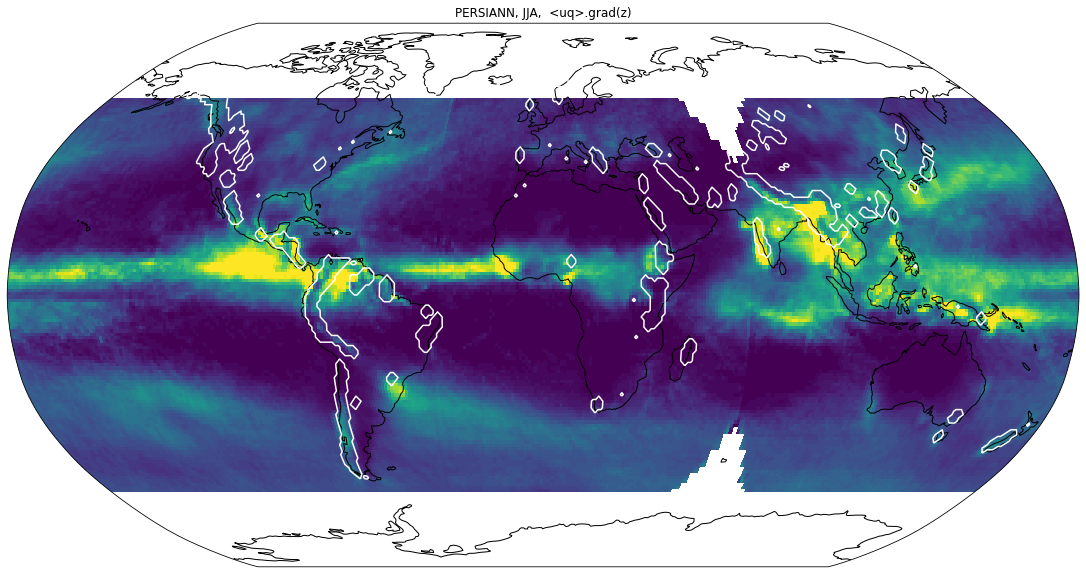

In [77]:
fig, ax = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.Robinson()})
plot_pr_mask(ax,0.2,persiann.sel(season='JJA'),viwvgradz_era5_seasmean_s_frogs.sel(season='JJA'),1)
ax.set_title("PERSIANN, JJA,  <uq>.grad(z)")


In [53]:
t=time.time()
kernel_mean_jja = spaceVaryingAnisotropicKernel(np.array(u100m_era5_seasmean.sel(season='JJA')),np.array(v100m_era5_seasmean.sel(season='JJA')),4)
print(time.time()-t)

190.32740378379822


In [85]:
t=time.time()
kernel_mean_jja2 = spaceVaryingAnisotropicKernel(np.array(u100m_era5_seasmean.sel(season='JJA')),np.array(v100m_era5_seasmean.sel(season='JJA')),2)
print(time.time()-t)

161.20248222351074


In [92]:
t=time.time()
kernel_mean_jja2prime = spaceVaryingAnisotropicKernel(np.array(u100m_era5_seasmean.sel(season='JJA')),np.array(v100m_era5_seasmean.sel(season='JJA')),2,1.5)
print(time.time()-t)

161.04372644424438


0.7808165550231934
Area fraction = 4.46 %


Text(0.5, 1.0, 'TRMM, whole year,  <uq>.grad(z)')

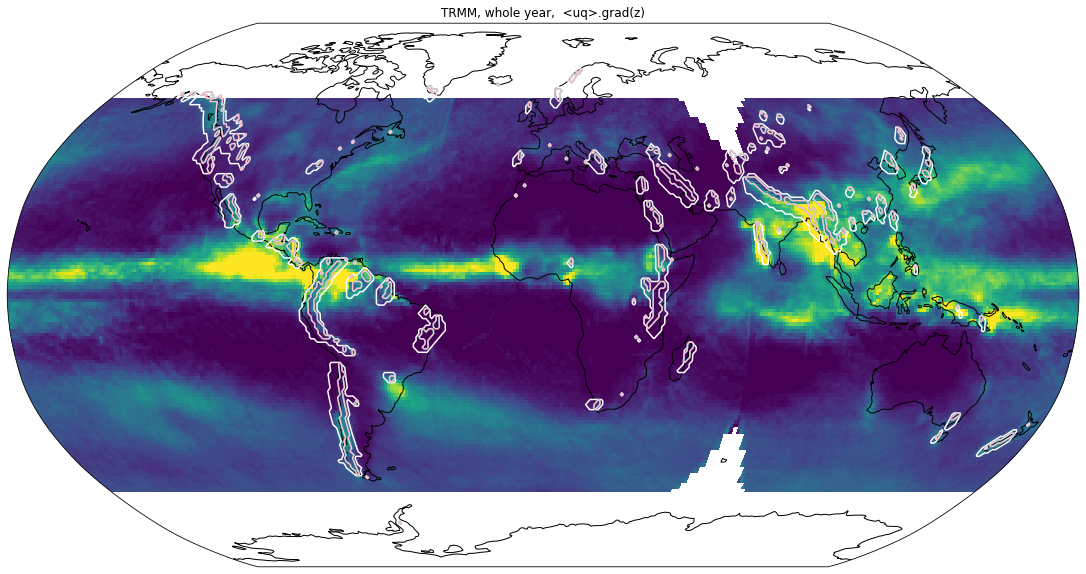

In [102]:
fig, ax = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.Robinson()})
plot_pr_anisotropic_mask(ax,0.2,persiann.sel(season='JJA'),viwvgradz_era5_seasmean_s_frogs.sel(season='JJA'),kernel_mean_jja2prime)
ax.set_title("TRMM, whole year,  <uq>.grad(z)")
